In [394]:
import json
import pandas as pd
from processing import tokenization_tagging, stopwords_removal, simple_headline_cleaning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import nltk
import numpy as np
import spacy
from textblob import TextBlob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [395]:
# Only relevant parts of the training dataset is the text and the rating so we will extract that

review_dict = {
    'reviewText' : [],
    'rating' : []
}

with open("amazonBooks_small_10000_sentiments.json", 'r') as review_json:
    for review in review_json:
        review_dict['reviewText'].append(json.loads(review)['reviewText'])
        review_dict['rating'].append(json.loads(review)['overall'])

sentiments = pd.DataFrame(review_dict)

In [396]:
sentiments.head()

,reviewText,rating
0,"I bought both boxed sets, books 1-5. Really a...",5.0
1,I enjoyed this short book. But it was way way ...,3.0
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4.0
3,I really enjoyed this adventure and look forwa...,4.0
4,It was a decent read.. typical story line. Not...,3.0


In [397]:
# Clean amazon reviewText
sentiments['reviewText'] = sentiments['reviewText'].apply(simple_headline_cleaning)
sentiments['reviewText_lemmatized'] = sentiments['reviewText'].apply(tokenization_tagging)
sentiments['reviewText_cleaned'] = sentiments['reviewText_lemmatized'].apply(stopwords_removal)
sentiments.sample(5)

,reviewText,rating,reviewText_lemmatized,reviewText_cleaned
1873,as readers of webers books know he ranks with ...,5.0,as reader of weber book know he rank with the ...,reader weber book know rank best give first bo...
9993,ive tried to start this graphic novel a couple...,2.0,ive try to start this graphic novel a couple o...,ive try start graphic novel couple time drab c...
7903,i like to order these books to have on hand fo...,4.0,i like to order these book to have on hand for...,like order book hand grandchild love look hidd...
6317,this is the fourth book in the series it was ...,4.0,this be the fourth book in the series it be go...,fourth book series good begin drag bit im stil...
6760,ive read every book in this series and they ar...,5.0,ive read every book in this series and they be...,ive read every book series awesome fun easy re...


In [398]:
# Data for training classifier 
X = sentiments[['reviewText_cleaned']]
y = sentiments['rating']
print("Shape of X: ", X.shape, "Shape of y: ", y.shape)

Shape of X:  (10000, 1) Shape of y:  (10000,)


In [399]:
#Train-Test Split for sentiment data
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.2)
print ('x_train',x_train.shape, 'x_test',x_test.shape, 'y_train',y_train.shape, 'y_test',y_test.shape)

x_train (8000, 1) x_test (2000, 1) y_train (8000,) y_test (2000,)


In [400]:
# Training the model
vectorizer = CountVectorizer()
matrix_train = vectorizer.fit_transform(x_train['reviewText_cleaned'])

classifier = MultinomialNB()
classifier.fit(matrix_train,y_train)

MultinomialNB()

In [401]:
# Define the parameter grid to search over
param_grid = {'alpha': np.logspace(-10, 1, 400)}


# Train a Naive Bayes classifier using cross-validation to find the best value of alpha
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(matrix_train, y_train)

# Print the best value of alpha and the corresponding cross-validation score
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Cross-validation score: {grid_search.best_score_:.2f}")

# Evaluate the best classifier on the test data
clf_best = grid_search.best_estimator_
x_test_vect = vectorizer.transform(x_test['reviewText_cleaned'])
accuracy = clf_best.score(x_test_vect, y_test)
print(f"Test accuracy with best alpha: {accuracy:.2f}")

Best alpha: 0.9548823692395637
Cross-validation score: 0.60
Test accuracy with best alpha: 0.59


In [402]:
classifier = MultinomialNB(alpha=grid_search.best_params_['alpha'])
classifier.fit(matrix_train,y_train)

MultinomialNB(alpha=0.9548823692395637)

In [403]:
# Evaluating the model
matrix_test = vectorizer.transform(x_test['reviewText_cleaned'])
predicted_results = classifier.predict(matrix_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, predicted_results)
precision = precision_score(y_test, predicted_results, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_results, average='weighted')
f1 = f1_score(y_test, predicted_results, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.59
Precision: 0.45
Recall: 0.59
F1 score: 0.48


[[   0    0    2    8   46]
 [   0    0    4   16   57]
 [   0    0    1   50  146]
 [   0    0    2   57  460]
 [   0    0    0   32 1119]]


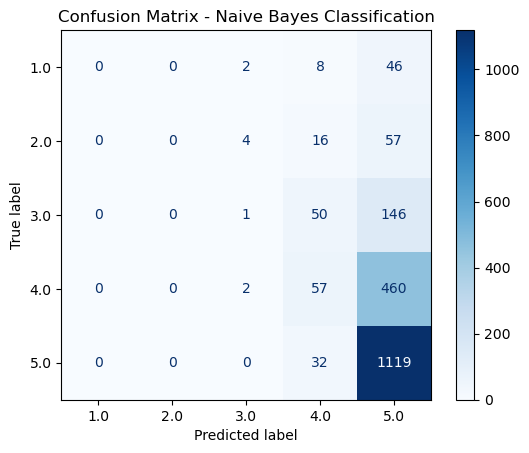

In [404]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_results)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(classifier, matrix_test, y_test,
                                             cmap=plt.cm.Blues,
                                             values_format='')
disp.ax_.set_title('Confusion Matrix - Naive Bayes Classification')

print(disp.confusion_matrix)

plt.show()


In [405]:
# Importing data
def open_file(filepath):
    with open(filepath) as f:
        return json.load(f)
    


In [406]:
kr_asia = open_file("../data_collection/exports/krasia.json")
today = open_file("../data_collection/exports/today.json")
cna = open_file("../data_collection/exports/cna.json")
aseanpost = open_file("../data_collection/exports/asean.json")
bbc = open_file("../data_collection/exports/bbc.json")

In [407]:
news = pd.concat([pd.DataFrame(kr_asia), pd.DataFrame(today), 
                  pd.DataFrame(cna),  pd.DataFrame(aseanpost),  pd.DataFrame(bbc)])
news.head()

,title,url,description,date,category,keywords,source,region
0,Unlocking the Power of ESOPs: Seminar on Attra...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,None,krasia,ASIA
1,Osaka cafe blends real-world and virtual touri...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,None,krasia,ASIA
2,The Uptake | Monday Musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,None,krasia,ASIA
3,ByteDance Launches Fast-Fashion Clothing Store...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,None,krasia,ASIA
4,"Europe, Japan can help ease rollout of EV batt...",https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,None,krasia,ASIA


In [408]:
## Pre-process titles
news['title'] = news['title'].apply(simple_headline_cleaning)
news['title_lemmatized'] = news['title'].apply(tokenization_tagging)
news['title_cleaned'] = news['title_lemmatized'].apply(stopwords_removal)
news.sample(5)

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned
4,europe japan can help ease rollout of ev batte...,https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,None,krasia,ASIA,europe japan can help ease rollout of ev batte...,europe japan help ease rollout ev battery rule...
16,major markets tumble on heightened recession f...,/markets/2022/jun/14/major-markets-tumble-heig...,"The dollar, however, gained versus major rivals.",2022-06-14T10:59:00+0800,None,"aseanpost, ASEAN Post, The ASEAN Post, theasea...",asean,SEA,major market tumble on heighten recession fear,major market tumble heighten recession fear
0,the plan to make a giant hot water bottle unde...,https://www.bbc.com/news/business-65098792,Hot water can be stored underground and the he...,2023-04-13 23:04:37,Business,"[BBC News, yes, BBC News, #bb1919, on, https:/...",bbc,INTERNATIONAL,the plan to make a giant hot water bottle unde...,plan make giant hot water bottle underground
33,chai chee western food stall sells crispy frie...,https://www.todayonline.com//8days/chai-chee-w...,Very value-for-money if you have a large gathe...,2023-04-20 18:20:49,,"[Crispy Wings Western Delights, chicken wings,...",today,LOCAL,chai chee western food stall sell crispy fry c...,chai chee western food stall sell crispy fry c...
3,when bicycles collide need for speed lack of e...,https://www.todayonline.com//singapore/group-c...,"SINGAPORE — A lack of etiquette, a disregard f...",2023-04-20 18:20:46,,"[cyclist, cycling, road safety]",today,LOCAL,when bicycle collide need for speed lack of et...,bicycle collide need speed lack etiquette top ...


In [409]:
def word_count(string):
    string = string.split(' ')
    return len(string)

def named_entities_extraction(text):
    nlp = spacy.load("en_core_web_sm")

    # Process the input text with spaCy
    doc = nlp(text)

    # Extract named entities from the document
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    return entities

In [410]:
news['headline_word_count'] = news['title'].apply(word_count)
news['named_entities'] = news['title'].apply(named_entities_extraction)

In [411]:
news.head()

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities
0,unlocking the power of esops seminar on attrac...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,None,krasia,ASIA,unlock the power of esop seminar on attract to...,unlock power esop seminar attract top talent,10,[]
1,osaka cafe blends realworld and virtual touris...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,None,krasia,ASIA,osaka cafe blend realworld and virtual tourism...,osaka cafe blend realworld virtual tourism hyb...,11,"[(osaka, GPE)]"
2,the uptake monday musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,None,krasia,ASIA,the uptake monday musing,uptake monday musing,5,"[(monday, DATE)]"
3,bytedance launches fastfashion clothing store ...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,None,krasia,ASIA,bytedance launch fastfashion clothing store on...,bytedance launch fastfashion clothing store do...,8,[]
4,europe japan can help ease rollout of ev batte...,https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,None,krasia,ASIA,europe japan can help ease rollout of ev batte...,europe japan help ease rollout ev battery rule...,12,"[(japan, GPE)]"


In [412]:
## Applying classifier
news_matrix = vectorizer.transform(news['title_cleaned'])
news_results = classifier.predict(news_matrix)
news['rating'] = news_results
news.head()

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities,rating
0,unlocking the power of esops seminar on attrac...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,None,krasia,ASIA,unlock the power of esop seminar on attract to...,unlock power esop seminar attract top talent,10,[],5.0
1,osaka cafe blends realworld and virtual touris...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,None,krasia,ASIA,osaka cafe blend realworld and virtual tourism...,osaka cafe blend realworld virtual tourism hyb...,11,"[(osaka, GPE)]",4.0
2,the uptake monday musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,None,krasia,ASIA,the uptake monday musing,uptake monday musing,5,"[(monday, DATE)]",5.0
3,bytedance launches fastfashion clothing store ...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,None,krasia,ASIA,bytedance launch fastfashion clothing store on...,bytedance launch fastfashion clothing store do...,8,[],5.0
4,europe japan can help ease rollout of ev batte...,https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,None,krasia,ASIA,europe japan can help ease rollout of ev batte...,europe japan help ease rollout ev battery rule...,12,"[(japan, GPE)]",5.0


In [413]:
### Create keywords for news articles that don't already have a keyword
## Keywords are created from the headlines
nltk.download('punkt')

def extract_keywords(text):
    blob = TextBlob(text.lower())
    keywords = [word for word in blob.words if word not in nltk.corpus.stopwords.words('english')]
    return keywords

[nltk_data] Downloading package punkt to /Users/tohdekai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [414]:
news['keywords'] = news.apply(lambda row: extract_keywords(row['title_cleaned']) if row['keywords'] == None else row['keywords'], axis=1)

In [415]:
news.head()

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities,rating
0,unlocking the power of esops seminar on attrac...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,"[unlock, power, esop, seminar, attract, top, t...",krasia,ASIA,unlock the power of esop seminar on attract to...,unlock power esop seminar attract top talent,10,[],5.0
1,osaka cafe blends realworld and virtual touris...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,"[osaka, cafe, blend, realworld, virtual, touri...",krasia,ASIA,osaka cafe blend realworld and virtual tourism...,osaka cafe blend realworld virtual tourism hyb...,11,"[(osaka, GPE)]",4.0
2,the uptake monday musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,"[uptake, monday, musing]",krasia,ASIA,the uptake monday musing,uptake monday musing,5,"[(monday, DATE)]",5.0
3,bytedance launches fastfashion clothing store ...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,"[bytedance, launch, fastfashion, clothing, sto...",krasia,ASIA,bytedance launch fastfashion clothing store on...,bytedance launch fastfashion clothing store do...,8,[],5.0
4,europe japan can help ease rollout of ev batte...,https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,"[europe, japan, help, ease, rollout, ev, batte...",krasia,ASIA,europe japan can help ease rollout of ev batte...,europe japan help ease rollout ev battery rule...,12,"[(japan, GPE)]",5.0


## Description of final table

In [416]:
news.shape

(138, 13)

In [417]:
# Convert the date column to a datetime object and set timezone information
news['date'] = pd.to_datetime(news['date'],utc=True)


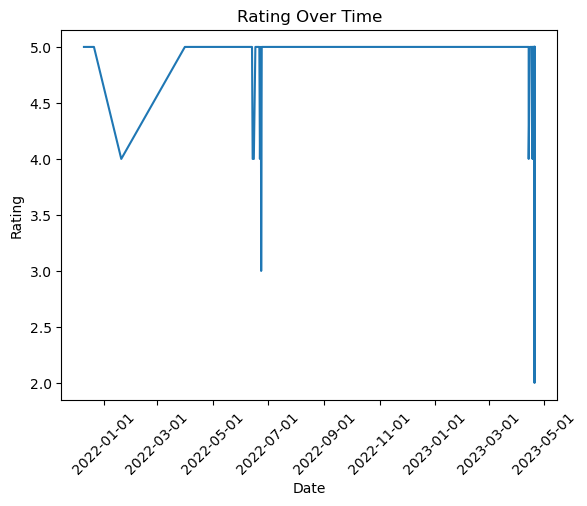

In [418]:
# Create the line chart
# Calculate the median rating for each date
median_ratings = news.groupby('date')['rating'].median()

fig, ax = plt.subplots()
ax.plot(median_ratings.index, median_ratings.values)

# Format the x-axis labels
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)

# Add axis labels and title
plt.xlabel('Date')
plt.ylabel('Rating')
plt.title('Rating Over Time')

# Show the chart
plt.show()

<AxesSubplot:xlabel='source'>

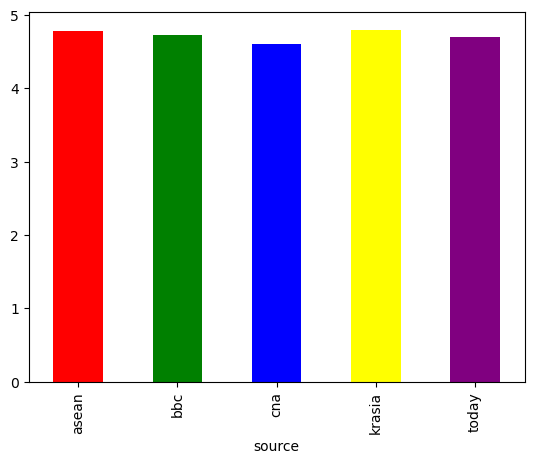

In [419]:
news.groupby('source')['rating'].mean().plot(kind='bar',color=['red','green','blue','yellow','purple'])


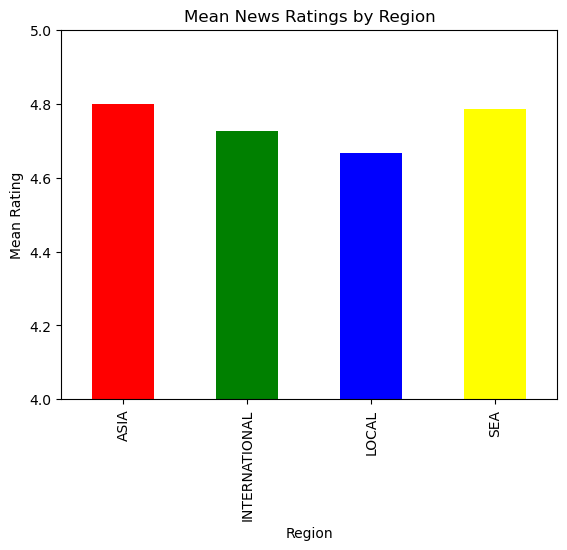

In [420]:

# Group the news DataFrame by region and calculate the mean rating for each group
mean_ratings = news.groupby('region')['rating'].mean()

# Create a bar plot with different colors for each bar
ax = mean_ratings.plot(kind='bar', color=['red', 'green', 'blue', 'yellow', 'purple'])

# Set the y-axis limits between 4 and 5
ax.set_ylim([4, 5])

# Add axis labels and a title
ax.set_xlabel('Region')
ax.set_ylabel('Mean Rating')
ax.set_title('Mean News Ratings by Region')

# Show the plot
plt.show()


In [391]:
# Business function: Filter by keyword
# Allow input for keyword and filter news article that has that word as a keyword

def filter_keyword(keywords, keyword):
    return keyword in keywords

In [392]:
input_value = "Singapore" # Insert input value here
filtered_news = news[news['keywords'].apply(lambda x: filter_keyword(x, input_value))]

filtered_news.head()

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities,rating
4,ong ye kung rebuts opposition mps says governm...,https://www.channelnewsasia.com/singapore/ong-...,Health Minister Ong Ye Kung said the governmen...,2023-04-20 08:34:00+00:00,www.channelnewsasia.com,"Singapore Parliament,The Workers' Party,Worker...",cna,LOCAL,ong ye kung rebuts opposition mp say governmen...,ong ye kung rebuts opposition mp say governmen...,15,[],4.0
